# License

***

Copyright 2018 Lingyao Meng (danielle@h2o.ai), J. Patrick Hall (phall@h2o.ai), and the H2O.ai team. 

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:
The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

# Imports and Setup

***

In [1]:
import os
import time
import sys

from data_maker_and_getter import DataMakerAndGetter
import eli5
import eli5.xgboost
import h2o
from lime_explainer import LIMEExplainer
import matplotlib.pyplot as plt
import numpy as np
from numpy import loadtxt
import pandas as pd
import shap
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance

In [2]:
%matplotlib inline

In [3]:
# load JS visualization code to notebook
shap.initjs() 

In [4]:
h2o.init(max_mem_size='12G')
h2o.remove_all()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_112"; Java(TM) SE Runtime Environment (build 1.8.0_112-b16); Java HotSpot(TM) 64-Bit Server VM (build 25.112-b16, mixed mode)
  Starting server from /Users/phall/anaconda/lib/python3.5/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/tc/0ss1l73113j3wdyjsxmy1j2r0000gn/T/tmp539i7qyk
  JVM stdout: /var/folders/tc/0ss1l73113j3wdyjsxmy1j2r0000gn/T/tmp539i7qyk/h2o_phall_started_from_python.out
  JVM stderr: /var/folders/tc/0ss1l73113j3wdyjsxmy1j2r0000gn/T/tmp539i7qyk/h2o_phall_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,02 secs
H2O cluster version:,3.16.0.4
H2O cluster version age:,3 months and 13 days !!!
H2O cluster name:,H2O_from_python_phall_47kg83
H2O cluster total nodes:,1
H2O cluster free memory:,10.67 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"
H2O connection url:,http://127.0.0.1:54321
H2O connection proxy:,None


# Known Signal Generating Functions

***

The objective of this notebook is to test and compare local explanations created by the popular methods: LIME, Treeinterpreter, and Shapley on an XGBoost model trained on a known signal generating function with noise: 
<br>
\begin{gather*}
y = x_1 * x_4 + |x_8| * (x_9)^2 + e
\end{gather*}
<br>
In this notebook we prevent XGBoost from overfitting to the known signal by providing a validation set.

# Data Generation and XGBoost Training
***

In [5]:
ds_ = DataMakerAndGetter(nrows=200000, target='binary', one_function=True, noise=True)
rson = ds_.make_random_with_signal()

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [6]:
y = 'target'
X = [name for name in rson.columns if name not in [y,'row_id','function','cat1','cat2','cat3']]
print(X)

['num1', 'num2', 'num3', 'num4', 'num5', 'num6', 'num7', 'num8', 'num9', 'num10', 'num11', 'num12']


In [7]:
rson[y] = rson[y].asfactor()
train, valid, _ = rson.split_frame([0.4, 0.3], seed = 12345)
print(train.shape)
print(valid.shape)

(80049, 18)
(59947, 18)


In [8]:
rsontrain_pd = train.as_data_frame()
rsonvalid_pd = valid.as_data_frame()

In [9]:
rsontrain_dm = xgb.DMatrix(rsontrain_pd[X],
                           rsontrain_pd[y])
rsonvalid_dm = xgb.DMatrix(rsonvalid_pd[X],
                           rsonvalid_pd[y])

In [10]:
ave_y = rsontrain_pd['target'].mean()
print(ave_y)

0.42154180564404303


In [11]:
params = {
     'base_score': ave_y,
     'booster': 'gbtree',
     'colsample_bytree': 0.9,
     'eta': 0.01,
     'eval_metric': 'auc',
     'max_depth': 12,
     'nthread': 4,
     'objective': 'binary:logistic',
     'reg_alpha': 0.001,
     'reg_lambda': 0.01,
     'seed': 12345,
     'silent': 0,
     'subsample': 0.1}

watchlist = [(rsontrain_dm, 'train'), (rsonvalid_dm, 'eval')]

rson_model = xgb.train(params, 
                       rsontrain_dm, 
                       400,
                       early_stopping_rounds=50,
                       evals=watchlist, 
                       verbose_eval=True)

[0]	train-auc:0.677162	eval-auc:0.652103
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 50 rounds.
[1]	train-auc:0.772706	eval-auc:0.748202
[2]	train-auc:0.803704	eval-auc:0.778381
[3]	train-auc:0.81642	eval-auc:0.791165
[4]	train-auc:0.822323	eval-auc:0.796931
[5]	train-auc:0.822706	eval-auc:0.796478
[6]	train-auc:0.827881	eval-auc:0.800287
[7]	train-auc:0.832643	eval-auc:0.802519
[8]	train-auc:0.832567	eval-auc:0.802516
[9]	train-auc:0.835957	eval-auc:0.805112
[10]	train-auc:0.835417	eval-auc:0.804751
[11]	train-auc:0.837147	eval-auc:0.806585
[12]	train-auc:0.838166	eval-auc:0.807955
[13]	train-auc:0.839793	eval-auc:0.809493
[14]	train-auc:0.840975	eval-auc:0.81088
[15]	train-auc:0.841855	eval-auc:0.81189
[16]	train-auc:0.84387	eval-auc:0.813033
[17]	train-auc:0.844448	eval-auc:0.812434
[18]	train-auc:0.845402	eval-auc:0.812897
[19]	train-auc:0.84675	eval-auc:0.813918
[20]	train-auc:0.846676	eval-auc:0

# Global Variable Importance 

***

#### XGBoost variable importance

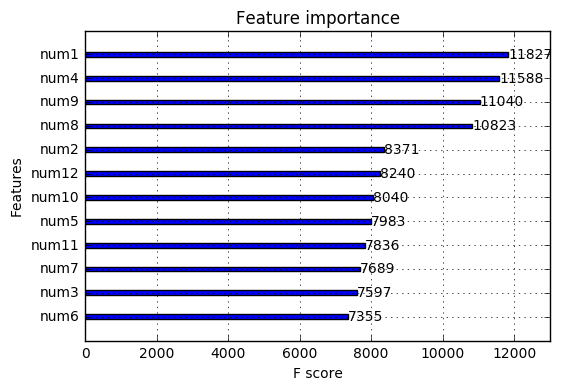

In [12]:
_ = plot_importance(rson_model)

#### Eli5/Tree Interpreter variable importance

In [13]:
eli5.show_weights(rson_model)

Weight,Feature
0.1350,num9
0.1148,num4
0.1133,num1
0.1026,num8
0.0681,num12
0.0670,num3
0.0669,num2
0.0668,num11
0.0667,num7
0.0667,num5


#### Shapley variable importance

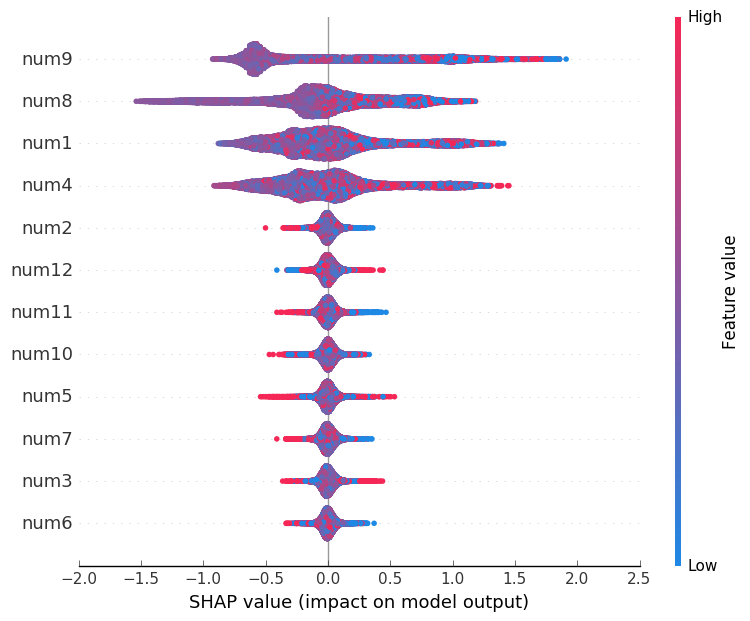

In [14]:
shap_values = rson_model.predict(rsonvalid_dm, pred_contribs=True)
shap.summary_plot(shap_values, rsonvalid_pd[X])

#### Example Shapley dependence (you can try other variables)

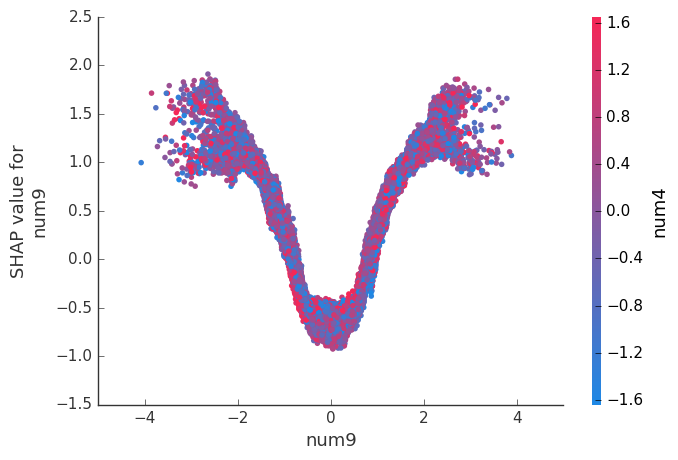

In [15]:
var = "num9" 
shap.dependence_plot(var, shap_values, rsonvalid_pd[X])

# Local Explanations (variable importance) at Several Percentiles of Model Predictions

***

#### Bind XGBoost predictions to training data

In [16]:
rson_preds = pd.DataFrame(rson_model.predict(rsonvalid_dm))

In [17]:
rson_decile_frame = pd.concat([rsonvalid_pd, rson_preds], axis=1)
rson_decile_frame = rson_decile_frame.rename(columns={0: 'predict'})
rson_decile_hframe = h2o.H2OFrame(rson_decile_frame)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [18]:
rson_decile_frame.head()

,num1,num2,num3,num4,num5,num6,num7,num8,num9,num10,num11,num12,cat1,cat2,cat3,target,row_id,function,predict
0,0.274992,0.228913,1.352917,0.886429,-2.001637,-0.371843,1.669025,-0.438570,-0.539741,0.476985,3.248944,-1.021228,GGGGGGGG,CCCCCCCC,BBBBBBBB,0,1,1,0.253521
1,0.331286,1.349742,0.069877,0.246674,-0.011862,1.004812,1.327195,-0.919262,-1.549106,0.022185,0.758363,-0.660524,DDDDDDDD,AAAAAAAA,DDDDDDDD,1,4,1,0.791636
2,0.862580,-0.010032,0.050009,0.670216,0.852965,-0.955869,-0.023493,-2.304234,-0.652469,-1.218302,-1.332610,1.074623,BBBBBBBB,CCCCCCCC,AAAAAAAA,1,5,1,0.556408
3,0.723642,0.690002,1.001543,-0.503087,-0.622274,-0.921169,-0.726213,0.222896,0.051316,-1.157719,0.816707,0.433610,CCCCCCCC,GGGGGGGG,FFFFFFFF,0,6,1,0.137169
4,-2.252797,-1.166832,0.353607,0.702110,-0.274569,-0.139142,0.107657,-0.606545,-0.417064,-0.017007,-1.224145,-1.800840,FFFFFFFF,DDDDDDDD,CCCCCCCC,1,10,1,0.247447


#### Find percentiles of XGBoost predictions

In [19]:
rson_percentile_dict = ds_.get_percentile_dict('predict', 'row_id', rson_decile_hframe)

In [20]:
rson_percentile_dict

{0: 118533,
 10: 21027,
 20: 20688,
 30: 80415,
 40: 31411,
 50: 193896,
 60: 169121,
 70: 129676,
 80: 172479,
 90: 5199,
 99: 191654}

# Explanation at each decile

#### Utility functions that displays the expected contribution of relevant variables with a short description at the chosen decile

In [21]:
def get_decile_describe(decile):
    
    row = rson_decile_frame[rson_decile_frame['row_id'] == rson_percentile_dict[decile]]
    print("This is the %dth decile of the predicted value with row_id %d, target %d, and prediction %.2f Base value: %.2f " 
          % (decile, row['row_id'].item(), row['target'].item(), row['predict'].item(), shap_values[row.index[0],:][-1]))
    print ("Signal generation function 1")
    return print_function1_contribs(row)
    
def print_function1_contribs(row):
    
    num1_contrib = row['num1'].iloc[0]
    print('Expected num1 contribution:', num1_contrib)
    
    num4_contrib = row['num4'].iloc[0]
    print('Expected num4 contribution:', num4_contrib)
    
    num8_contrib = np.abs(row['num8'].iloc[0]) 
    print('Expected num8 contribution:', num8_contrib)
    
    num9_contrib = np.power(row['num9'].iloc[0], 2)
    print('Expected num9 contribution:', num9_contrib)

#### Utility function that displays the TreeInterpreter plot at the chosen decile 

In [22]:
def eli5_dd(decile):
    row = rson_decile_frame[rson_decile_frame['row_id'] == rson_percentile_dict[decile]]
    return eli5.explain_prediction_xgboost(rson_model, row[X].iloc[0])

#### Utility function that displays the LIME result at the choosen decile

In [23]:
# learn what to discretize from var imp 
explainer = LIMEExplainer(training_frame=rsonvalid_pd, X=X, model=rson_model, 
                          discretize=['num1', 'num4', 'num8', 'num9'])

def lime(decile):
    row = rson_decile_frame[rson_decile_frame['row_id'] == rson_percentile_dict[decile]]
    explainer.explain(row.index[0]) 

##  10th decile of model predictions

In [24]:
decile = 10
row = rson_decile_frame[rson_decile_frame['row_id'] == rson_percentile_dict[decile]]
get_decile_describe(decile)

This is the 10th decile of the predicted value with row_id 21027, target 0, and prediction 0.18 Base value: -0.31 
Signal generation function 1
Expected num1 contribution: -0.375180554378
Expected num4 contribution: -0.778432868185
Expected num8 contribution: 0.276291941948
Expected num9 contribution: 0.0315202288707


### Shapley values

       Approximate Local Contributions
num1                         -0.274346
num2                         -0.035755
num3                         -0.017705
num4                         -0.014629
num5                          0.007957
num6                         -0.021440
num7                         -0.040775
num8                         -0.135782
num9                         -0.642036
num10                        -0.018131
num11                        -0.008622
num12                         0.016731 

Shapley sum:  -1.49461
Model prediction:  -1.49461446207


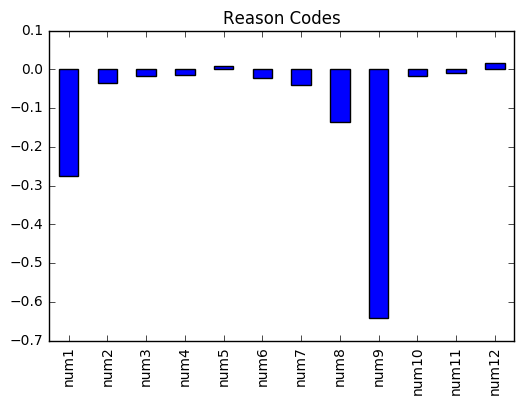

In [25]:
s_df = pd.DataFrame(shap_values[row.index[0], :][:-1].reshape(12, 1), columns=['Approximate Local Contributions'], index=X)
print(s_df, '\n')
_= s_df.plot(kind='bar', title='Reason Codes', legend=False)
print('Shapley sum: ', s_df['Approximate Local Contributions'].sum() + shap_values[row.index[0], -1])
p = row['predict'].values[0]
print('Model prediction: ', np.log(p/(1 - p)))

### TreeInterpreter

In [26]:
eli5_dd(decile)

Explanation(estimator='<xgboost.core.Booster object at 0x12851fda0>', description='\nFeatures with largest coefficients.\n\nFeature weights are calculated by following decision paths in trees\nof an ensemble. Each leaf has an output score, and expected scores can also be\nassigned to parent nodes. Contribution of one feature on the decision path\nis how much expected score changes from parent to child. Weights of all \nfeatures sum to the output score of the estimator.\n\nCaveats:\n1. Feature weights just show if the feature contributed positively or\n   negatively to the final score, and does show how increasing or decreasing\n   the feature value will change the prediction.\n2. In some cases, feature weight can be close to zero for an important feature.\n   For example, in a single tree that computes XOR function, the feature at the\n   top of the tree will have zero weight because expected scores for both\n   branches are equal, so decision at the top feature does not change the\n   expected score. For an ensemble predicting XOR functions it might not be\n   a problem, but it is not reliable if most trees happen to choose the same\n   feature at the top.\n', error=None, method='decision paths', is_regression=True, targets=[TargetExplanation(target='y', feature_weights=FeatureWeights(pos=[FeatureWeight(feature='num12', weight=0.01673137191394768, std=None, value=-0.45573749567350569), FeatureWeight(feature='num5', weight=0.0079566399428495343, std=None, value=0.45615527891474522), FeatureWeight(feature='<BIAS>', weight=0.0063664502672176057, std=None, value=1.0)], neg=[FeatureWeight(feature='num9', weight=-0.64203636509299411, std=None, value=-0.17753937273387407), FeatureWeight(feature='num1', weight=-0.27434633776842676, std=None, value=-0.37518055437761888), FeatureWeight(feature='num8', weight=-0.13578212132540016, std=None, value=-0.27629194194771167), FeatureWeight(feature='num7', weight=-0.040774689107959582, std=None, value=-0.040104645798723852), FeatureWeight(feature='num2', weight=-0.035755038256372274, std=None, value=-0.26719162562308651), FeatureWeight(feature='num6', weight=-0.021440281607478358, std=None, value=0.64114888765859734), FeatureWeight(feature='num10', weight=-0.018131341805074329, std=None, value=0.18344683628153119), FeatureWeight(feature='num3', weight=-0.017705020257743957, std=None, value=-0.48213367632242182), FeatureWeight(feature='num4', weight=-0.014628894436234651, std=None, value=-0.77843286818511293), FeatureWeight(feature='num11', weight=-0.0086216932663311374, std=None, value=-0.52051448517401844)], pos_remaining=0, neg_remaining=0), proba=None, score=-1.1781673207999996, weighted_spans=None)], feature_importances=None, decision_tree=None, highlight_spaces=None, transition_features=None)

In [27]:
p = row['predict'].values[0]
print('\nModel prediction: ', np.log(p/(1 - p)))


Model prediction:  -1.49461446207


### LIME


Model Prediction: 0.18
Local GLM Prediction: 0.13
Local GLM R-square: 0.64
Local GLM Intercept: 0.52

Approximate Local Contributions:
                   Input  Local Contribution
0   num1.(-0.386, 0.297]       -1.015841e-01
1  num4.(-0.789, -0.109]       -8.795355e-02
2   num8.(-0.287, 0.392]       -8.164420e-02
3   num9.(-0.188, 0.491]       -7.840117e-02
4                   num2       -2.537946e-02
5                   num3       -8.702176e-03
6                   num7       -4.049041e-07
7                   num6        1.442442e-04
8                   num5        9.889014e-04
None


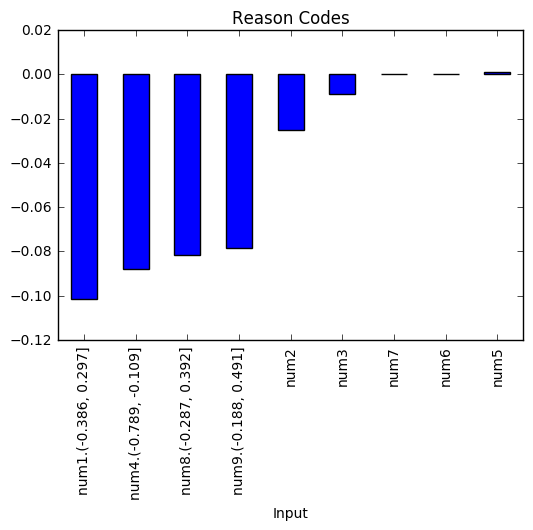

In [28]:
lime(decile)

##  Median of predictions

### Shapley values

In [29]:
decile = 50
row = rson_decile_frame[rson_decile_frame['row_id'] == rson_percentile_dict[decile]]
get_decile_describe(decile)

This is the 50th decile of the predicted value with row_id 193896, target 0, and prediction 0.32 Base value: -0.31 
Signal generation function 1
Expected num1 contribution: 1.13685017796
Expected num4 contribution: -1.3955848876
Expected num8 contribution: 1.25982004397
Expected num9 contribution: 0.638285889444


       Approximate Local Contributions
num1                         -0.407147
num2                         -0.053691
num3                         -0.011071
num4                         -0.288519
num5                          0.096362
num6                         -0.014388
num7                          0.056653
num8                          0.402506
num9                         -0.221296
num10                        -0.021143
num11                        -0.073576
num12                         0.069635 

Shapley sum:  -0.775755
Model prediction:  -0.775755301644


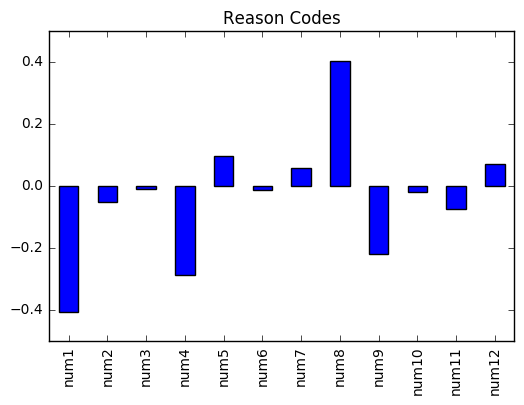

In [30]:
s_df = pd.DataFrame(shap_values[row.index[0], :][:-1].reshape(12, 1), columns=['Approximate Local Contributions'], index=X)
print(s_df, '\n')
_= s_df.plot(kind='bar', title='Reason Codes', legend=False)
print('Shapley sum: ', s_df['Approximate Local Contributions'].sum() + shap_values[row.index[0], -1])
p = row['predict'].values[0]
print('Model prediction: ', np.log(p/(1 - p)))

### TreeInterpreter 

In [31]:
eli5_dd(decile)

Explanation(estimator='<xgboost.core.Booster object at 0x12851fda0>', description='\nFeatures with largest coefficients.\n\nFeature weights are calculated by following decision paths in trees\nof an ensemble. Each leaf has an output score, and expected scores can also be\nassigned to parent nodes. Contribution of one feature on the decision path\nis how much expected score changes from parent to child. Weights of all \nfeatures sum to the output score of the estimator.\n\nCaveats:\n1. Feature weights just show if the feature contributed positively or\n   negatively to the final score, and does show how increasing or decreasing\n   the feature value will change the prediction.\n2. In some cases, feature weight can be close to zero for an important feature.\n   For example, in a single tree that computes XOR function, the feature at the\n   top of the tree will have zero weight because expected scores for both\n   branches are equal, so decision at the top feature does not change the\n   expected score. For an ensemble predicting XOR functions it might not be\n   a problem, but it is not reliable if most trees happen to choose the same\n   feature at the top.\n', error=None, method='decision paths', is_regression=True, targets=[TargetExplanation(target='y', feature_weights=FeatureWeights(pos=[FeatureWeight(feature='num8', weight=0.40250579755267851, std=None, value=1.2598200439710596), FeatureWeight(feature='num5', weight=0.096362440209862815, std=None, value=-1.0821940500604808), FeatureWeight(feature='num12', weight=0.069634553417697059, std=None, value=-0.70147675237856344), FeatureWeight(feature='num7', weight=0.056652852074998539, std=None, value=0.29562194117960328), FeatureWeight(feature='<BIAS>', weight=0.0063664502672176057, std=None, value=1.0)], neg=[FeatureWeight(feature='num1', weight=-0.40714677531139781, std=None, value=1.1368501779580258), FeatureWeight(feature='num4', weight=-0.28851857798007813, std=None, value=-1.3955848875957382), FeatureWeight(feature='num9', weight=-0.22129586140711469, std=None, value=0.79892796261251486), FeatureWeight(feature='num11', weight=-0.07357598821069497, std=None, value=0.12241268744753435), FeatureWeight(feature='num2', weight=-0.053690522493078603, std=None, value=0.44947190831571793), FeatureWeight(feature='num10', weight=-0.021143096867905404, std=None, value=0.16981959758783335), FeatureWeight(feature='num6', weight=-0.014388142377200264, std=None, value=-1.2741522121708322), FeatureWeight(feature='num3', weight=-0.011070856474985076, std=None, value=0.34725668821944772)], pos_remaining=0, neg_remaining=0), proba=None, score=-0.4593077275999999, weighted_spans=None)], feature_importances=None, decision_tree=None, highlight_spaces=None, transition_features=None)

In [32]:
p = row['predict'].values[0]
print('\nModel prediction: ', np.log(p/(1 - p)))


Model prediction:  -0.775755301644


### LIME


Model Prediction: 0.32
Local GLM Prediction: 0.63
Local GLM R-square: 0.74
Local GLM Intercept: 0.51

Approximate Local Contributions:
                   Input  Local Contribution
0                   num2           -0.045057
1                   num3           -0.006839
2                   num7           -0.000014
3                   num6            0.000226
4                   num5            0.002894
5    num9.(0.788, 1.468]            0.031983
6    num8.(1.249, 1.928]            0.036505
7  num4.(-1.406, -0.726]            0.043693
8    num1.(1.126, 1.809]            0.058073
None


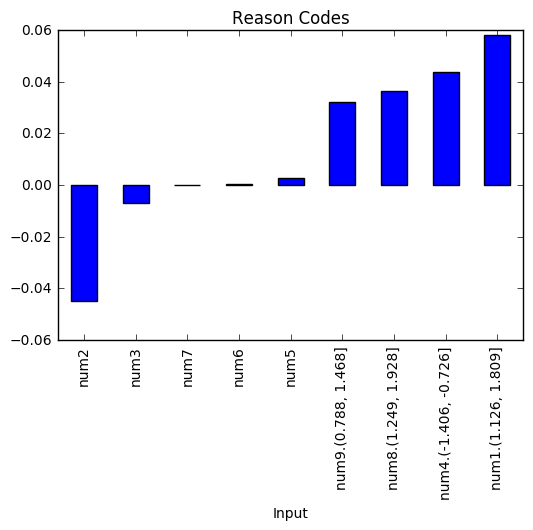

In [33]:
lime(decile)

##  90th decile of model predictions

In [34]:
decile = 90
row = rson_decile_frame[rson_decile_frame['row_id'] == rson_percentile_dict[decile]]
get_decile_describe(decile)

This is the 90th decile of the predicted value with row_id 5199, target 1, and prediction 0.78 Base value: -0.31 
Signal generation function 1
Expected num1 contribution: 2.18413107352
Expected num4 contribution: 1.06905191443
Expected num8 contribution: 1.30067660518
Expected num9 contribution: 0.717670931678


### Shapley values

       Approximate Local Contributions
num1                          0.370922
num2                          0.040477
num3                          0.005370
num4                          0.637055
num5                          0.062941
num6                         -0.102998
num7                         -0.009268
num8                          0.499683
num9                         -0.102361
num10                         0.099362
num11                         0.051654
num12                         0.015425 

Shapley sum:  1.25818
Model prediction:  1.25817990979


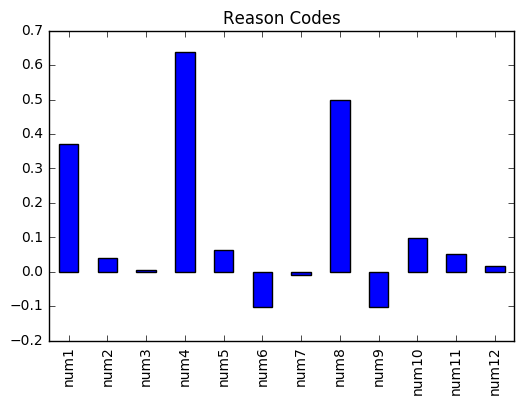

In [35]:
s_df = pd.DataFrame(shap_values[row.index[0], :][:-1].reshape(12, 1), columns=['Approximate Local Contributions'], index=X)
print(s_df, '\n')
_= s_df.plot(kind='bar', title='Reason Codes', legend=False)
print('Shapley sum: ', s_df['Approximate Local Contributions'].sum() + shap_values[row.index[0], -1])
p = row['predict'].values[0]
print('Model prediction: ', np.log(p/(1 - p)))

### TreeInterpreter

In [36]:
eli5_dd(decile)

Explanation(estimator='<xgboost.core.Booster object at 0x12851fda0>', description='\nFeatures with largest coefficients.\n\nFeature weights are calculated by following decision paths in trees\nof an ensemble. Each leaf has an output score, and expected scores can also be\nassigned to parent nodes. Contribution of one feature on the decision path\nis how much expected score changes from parent to child. Weights of all \nfeatures sum to the output score of the estimator.\n\nCaveats:\n1. Feature weights just show if the feature contributed positively or\n   negatively to the final score, and does show how increasing or decreasing\n   the feature value will change the prediction.\n2. In some cases, feature weight can be close to zero for an important feature.\n   For example, in a single tree that computes XOR function, the feature at the\n   top of the tree will have zero weight because expected scores for both\n   branches are equal, so decision at the top feature does not change the\n   expected score. For an ensemble predicting XOR functions it might not be\n   a problem, but it is not reliable if most trees happen to choose the same\n   feature at the top.\n', error=None, method='decision paths', is_regression=True, targets=[TargetExplanation(target='y', feature_weights=FeatureWeights(pos=[FeatureWeight(feature='num4', weight=0.63705514210701331, std=None, value=1.0690519144303203), FeatureWeight(feature='num8', weight=0.49968265718702987, std=None, value=-1.3006766051751641), FeatureWeight(feature='num1', weight=0.37092192404207175, std=None, value=2.1841310735157453), FeatureWeight(feature='num10', weight=0.099361612943393893, std=None, value=-0.065317844080371071), FeatureWeight(feature='num5', weight=0.062941160395688978, std=None, value=0.23672461833180891), FeatureWeight(feature='num11', weight=0.051653776688432664, std=None, value=-0.36441901036451491), FeatureWeight(feature='num2', weight=0.040476654665295035, std=None, value=-0.55144906355742629), FeatureWeight(feature='num12', weight=0.015425015663128969, std=None, value=-0.12577221141517814), FeatureWeight(feature='<BIAS>', weight=0.0063664502672176057, std=None, value=1.0), FeatureWeight(feature='num3', weight=0.0053699177133381924, std=None, value=-0.50173630192630736)], neg=[FeatureWeight(feature='num6', weight=-0.10299762344668287, std=None, value=3.5339434791174829), FeatureWeight(feature='num9', weight=-0.1023614928123355, std=None, value=-0.84715460907569939), FeatureWeight(feature='num7', weight=-0.0092678174135915579, std=None, value=-1.4705823058010348)], pos_remaining=0, neg_remaining=0), proba=None, score=1.5746273780000004, weighted_spans=None)], feature_importances=None, decision_tree=None, highlight_spaces=None, transition_features=None)

In [37]:
p = row['predict'].values[0]
print('\nModel prediction: ', np.log(p/(1 - p)))


Model prediction:  1.25817990979


### LIME


Model Prediction: 0.78
Local GLM Prediction: 0.72
Local GLM R-square: 0.37
Local GLM Intercept: 0.73

Approximate Local Contributions:
                    Input  Local Contribution
0     num1.(2.173, 2.856]       -2.258067e-03
1                    num5       -3.127333e-04
2                    num6       -2.578477e-04
3     num4.(1.058, 1.739]       -2.595508e-05
4   num8.(-1.311, -0.632]       -2.326772e-07
5   num9.(-0.858, -0.178]       -1.663772e-09
6                   num12        2.667781e-16
7                   num11        3.968322e-14
8                   num10        3.611118e-13
9                    num7        4.141837e-10
10                   num2        4.688314e-06
11                   num3        7.721161e-04
None


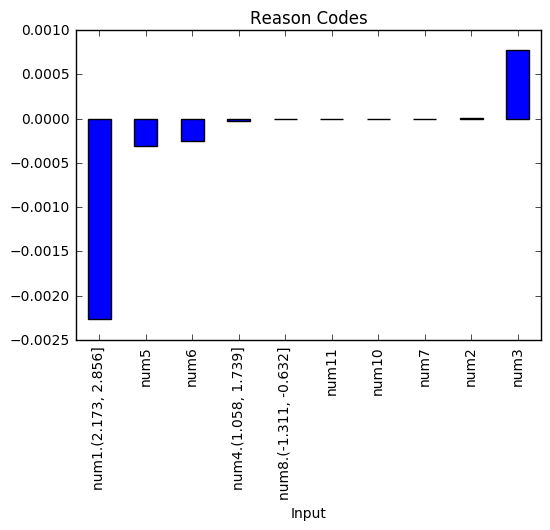

In [38]:
lime(decile)